In [1]:
# Cell 1: Import required libraries
import os
import yaml
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import your model and data loading components
from dataloader.dataset_wrapper import create_wrapper_from_dataframe

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Cell 2: Configuration and paths setup
CONFIG_PATH = "/Users/ivangolov/Desktop/Диплом/CSMP_project/CSMP_thesis_project/services/CSU-MS2/model/qtof_model/median_energy/checkpoints/config.yaml"
TRAIN_CSV_PATH = "/Users/ivangolov/Desktop/Диплом/CSMP_project/CSMP_spectrum_database/data/production/train_deduplicated.csv"
OUTPUT_DIR = "./train_results"

# Device selection for Mac
if torch.backends.mps.is_available():
    DEVICE = 'mps'
    print("Using MPS (Metal Performance Shaders) for GPU acceleration")
elif torch.cuda.is_available():
    DEVICE = 'cuda'
    print("Using CUDA for GPU acceleration")
else:
    DEVICE = 'cpu'
    print("Using CPU")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Validation data path: {TRAIN_CSV_PATH}")

Using MPS (Metal Performance Shaders) for GPU acceleration
Using device: mps
Validation data path: /Users/ivangolov/Desktop/Диплом/CSMP_project/CSMP_spectrum_database/data/production/train_deduplicated.csv


In [4]:
# Cell 3: Load configuration
print("Loading configuration...")
config = yaml.load(open(CONFIG_PATH, "r"), Loader=yaml.FullLoader)

print("Configuration loaded:")
print(f"- Batch size: {config.get('batch_size', 'Not specified')}")
print(f"- Model config keys: {list(config.get('model', {}).keys())}")
print(f"- Loss config: {config.get('loss', {})}")

Loading configuration...
Configuration loaded:
- Batch size: 64
- Model config keys: []
- Loss config: {'temperature': 0.1, 'use_cosine_similarity': True, 'alpha_weight': 0.75}


In [5]:
# Cell 4: Load and explore validation data
print("Loading train data...")
df_train = pd.read_csv(TRAIN_CSV_PATH)

print(f"Validation dataset shape: {df_train.shape}")
print(f"Columns: {list(df_train.columns)}")
print(f"Sample data:")
df_train.head()

Loading train data...
Validation dataset shape: (798444, 10)
Columns: ['peaks_json', 'ion_source', 'compound_source', 'instrument', 'adduct', 'precursor_mz', 'smiles', 'inchikey', 'ion_mode', 'molecular_formula']
Sample data:


,peaks_json,ion_source,compound_source,instrument,adduct,precursor_mz,smiles,inchikey,ion_mode,molecular_formula
0,"[[42.014248, 0.10199999999999998], [42.26601, ...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
1,"[[49.01717, 0.155], [49.020023, 0.253], [67.05...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
2,"[[49.017338, 0.242], [49.020237, 0.181], [67.0...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
3,"[[49.01701, 0.144], [49.019947, 0.244], [139.0...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
4,"[[49.017166, 0.155], [49.020008, 0.253], [139....",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3


In [6]:
df_train_sample = df_train.sample(n=10000,random_state=42).reset_index(drop=True)

In [6]:
# Cell 6: Prepare validation data loader
print("Preparing data loaders")

# Create data wrapper from DataFrame
wrapper, processed_df = create_wrapper_from_dataframe(
    df=df_train_sample,
    batch_size=64,  
    num_workers=8,
    valid_size=0.2,  
    use_ddp=False,
    output_dir="./train_features"
)

# Get the data loader
train_loader, val_loader = wrapper.get_data_loaders()

print(f"Successfully processed {len(processed_df)} samples")
print(f"Number of batches: {len(val_loader)}")

Preparing data loaders
Convert DataFrame to compatible files
Processed 10000 valid spectra out of 10000 total entries.
Create data wrapper
calculating molecular graphs


  2%|▏         | 168/8000 [00:00<00:04, 1669.71it/s]

SMILES [Cl-].O=C1C=2C=C(C(O)=C(C2OC(=C1C=3C=CC=4OCCOC4C3)C)C[NH+](C)C)CCC calculation failure
SMILES [Na+].O=C(CCCCCCCCCCC)CC(O)S(=O)(=O)[O-] calculation failure
SMILES [I-].O=C(OCC1=CC[N+]2(C)CCC(O)C12)C(O)(C(O)C)C(C)C calculation failure


  4%|▍         | 341/8000 [00:00<00:04, 1699.79it/s]

SMILES [Cl-].O=C1C2=CC=C(O)C(=C2OC(=C1C=3C=CC=4OCCCOC4C3)C)C[NH+](C)C calculation failure


 13%|█▎        | 1024/8000 [00:00<00:04, 1674.40it/s]

SMILES [Cl-].O=C1C(=COC2=C1C=C(C(O)=C2C[NH+](C)C)CC)C=3C=CC=4OCCOC4C3 calculation failure


 21%|██▏       | 1714/8000 [00:01<00:03, 1706.41it/s]

SMILES [K+].[K+].O=C([O-])C1OC(OC2C(OC(C(=O)[O-])C(O)C2O)OC3CCC4(C)C5C(=O)C=C6C7CC(C(=O)O)(C)CCC7(C)CCC6(C)C5(C)CCC4C3(C)C)C(O)C(O)C1O calculation failure
SMILES [I-].O=C(OCC1=CC[N+]2(C)CCC(O)C12)C(O)(C(O)C)C(C)C calculation failure


 28%|██▊       | 2224/8000 [00:01<00:03, 1670.49it/s]

SMILES [Na+].O=C(CCCCCCCCCCC)CC(O)S(=O)(=O)[O-] calculation failure


 40%|████      | 3231/8000 [00:01<00:02, 1660.80it/s]

SMILES [K+].O=C([O-])C12CCC(C(=C)C)C2C3CCC4C5(C)CCC(=O)C(C)(C)C5CCC4(C)C3(C)CC1 calculation failure


 55%|█████▍    | 4392/8000 [00:02<00:02, 1649.85it/s]

SMILES [Br-].O=C(OC1CC2C3OC3C(C1)[N+]2(C)CCCC)C(C=4C=CC=CC4)CO calculation failure
SMILES [Cl-].OC=1C=C(O)C=2C=C(OC3OC(CO)C(O)C(O)C3O)C(=[O+]C2C1)C=4C=CC(O)=C(O)C4 calculation failure
SMILES [Na+].O=C(CCCCCCCCCCC)CC(O)S(=O)(=O)[O-] calculation failure
SMILES [Cl-].O=C1C2=CC=C(O)C(=C2OC(=C1C=3C=CC=4OCCCOC4C3)C)C[NH+](C)C calculation failure


 61%|██████    | 4880/8000 [00:02<00:02, 1558.93it/s]

SMILES [Na+].O=P([O-])(O)OCC1OC(N2C=NC=3C(=NC=NC32)N)C(O)C1O calculation failure


 79%|███████▉  | 6306/8000 [00:03<00:01, 1237.81it/s]

SMILES [Cl-].O=C(O)C=1C=CC=CC1C=2C=3C=CC(=CC3OC4=CC(C=CC42)=[N+](CC)CC)N(CC)CC calculation failure
SMILES [K+].O=S(=O)([O-])ON=C(SC1OC(CO)C(O)C(O)C1O)CC=C.O calculation failure


 84%|████████▍ | 6706/8000 [00:04<00:01, 1232.19it/s]

SMILES [I-].O=C(OCC1=CC[N+]2(C)CCC(O)C12)C(O)(C(O)C)C(C)C calculation failure
SMILES CCC1=C(C2=NC1=CC3=C(C4=C([N-]3)C(=C5[C@H]([C@@H](C(=N5)C=C6C(=C(C(=C2)[N-]6)C=C)C)C)CCC(=O)OC/C=C(\C)/CCC[C@H](C)CCC[C@H](C)CCCC(C)C)[C@H](C4=O)C(=O)OC)C)C=O.[Mg+2] calculation failure


 93%|█████████▎| 7403/8000 [00:04<00:00, 1238.64it/s]

SMILES [Na+].O=C([O-])C(CC)C1OC(C(=CC=CC2C=CC3CCCC3C2C(=O)C4=CC=CN4)CC)C(C)CC1 calculation failure


100%|██████████| 8000/8000 [00:05<00:00, 1490.51it/s]


Calculated 6852 molecular graph-mass spectrometry pairs
calculating molecular graphs


  8%|▊         | 166/2000 [00:00<00:01, 1648.06it/s]

SMILES [Cl-].O=C1C2=CC=C(O)C(=C2OC(=C1C=3C=CC=4OCCCOC4C3)C)C[NH+](C)C calculation failure


 17%|█▋        | 337/2000 [00:00<00:00, 1680.53it/s]

SMILES [K+].O=S(=O)([O-])ON=C(SC1OC(CO)C(O)C(O)C1O)CC=C.O calculation failure


 68%|██████▊   | 1360/2000 [00:00<00:00, 1697.90it/s]

SMILES [I-].O=C(OCC1=CC[N+]2(C)CCC(O)C12)C(O)(C(O)C)C(C)C calculation failure


 85%|████████▌ | 1703/2000 [00:01<00:00, 1695.74it/s]

SMILES [Cl-].OC=1C=C(O)C=2C=C(OC3OC(CO)C(O)C(O)C3O)C(=[O+]C2C1)C=4C=CC(O)=C(O)C4 calculation failure
SMILES C1C(N(C2=C(N1)N=C(NC2=O)N)C=O)CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-].[Ca+2] calculation failure


100%|██████████| 2000/2000 [00:01<00:00, 1676.81it/s]

Calculated 1701 molecular graph-mass spectrometry pairs
Successfully processed 10000 samples
Number of batches: 27


In [7]:
from model import ModelCLR

# Initialize model architecture
model = ModelCLR(**config["model_config"]).to(DEVICE)

In [8]:
# Model Architecture Overview
print("MODEL ARCHITECTURE:")
print("-" * 40)
print(f"Model Type: {type(model).__name__}")
print(f"Device: {DEVICE}")

MODEL ARCHITECTURE:
----------------------------------------
Model Type: ModelCLR
Device: mps


In [9]:
# Submodules Analysis
print("SUBMODULES:")
print("-" * 40)
for name, module in model.named_children():
    print(f"{name:15}: {type(module).__name__}")
    if hasattr(module, '__dict__'):
        for attr_name, attr_value in module.__dict__.items():
            if not attr_name.startswith('_') and not callable(attr_value):
                if isinstance(attr_value, (int, float, str, bool)):
                    print(f"  {attr_name:12}: {attr_value}")

SUBMODULES:
----------------------------------------
Smiles_model   : SmilesModel
  training    : True
  num_layer   : 5
  emb_dim     : 300
  feat_dim    : 512
  drop_ratio  : 0.3
MS_model       : MSModel
  training    : True
smi_esa        : ESA_SMILES
  training    : True
spec_esa       : ESA_SPEC
  training    : True
smi_proj       : Linear
  training    : True
  in_features : 256
  out_features: 256
spec_proj      : Linear
  training    : True
  in_features : 256
  out_features: 256


In [10]:
# Parameter Count
print("PARAMETER ANALYSIS:")
print("-" * 40)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {total_params - trainable_params:,}")


PARAMETER ANALYSIS:
----------------------------------------
Total Parameters: 5,318,572
Trainable Parameters: 5,318,444
Non-trainable Parameters: 128


In [11]:
# Memory Usage (approximate)
print("MEMORY ANALYSIS:")
print("-" * 40)
param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024 / 1024

print(f"Model Size: {model_size_mb:.2f} MB")
print(f"Parameter Memory: {param_size / 1024 / 1024:.2f} MB")
print(f"Buffer Memory: {buffer_size / 1024 / 1024:.2f} MB")


MEMORY ANALYSIS:
----------------------------------------
Model Size: 20.30 MB
Parameter Memory: 20.29 MB
Buffer Memory: 0.01 MB


In [12]:
from loss.nt_xent import NTXentLoss

# Initialize loss function
temperature = config.get('loss', {}).get('temperature', 0.1)
batch_size = config.get('batch_size', 1024)
use_cosine_similarity = config.get('loss', {}).get('use_cosine_similarity', True)
alpha_weight = config.get('loss', {}).get('alpha_weight', 1.0)

criterion = NTXentLoss(
    device=DEVICE, 
    batch_size=batch_size, 
    temperature=temperature, 
    use_cosine_similarity=use_cosine_similarity, 
    alpha_weight=alpha_weight
)

In [13]:
# Cell 15: Training Setup and Optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import time
from collections import defaultdict

print("Setting up training components...")
OUTPUT_DIR = "./model"

# Initialize optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=float(config.get('learning_rate', 5e-6)),
    weight_decay=float(config.get('weight_decay', 1e-4))
)

# Initialize scheduler
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=config.get('epochs', 4000),
    eta_min=1e-7
)

# Training configuration
epochs = config.get('epochs', 4000)
eval_every_n_epochs = config.get('eval_every_n_epochs', 5)
log_every_n_steps = config.get('log_every_n_steps', 2)

# Create checkpoint directory
checkpoint_dir = os.path.join(OUTPUT_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Training for {epochs} epochs")
print(f"Optimizer: AdamW with lr={config.get('learning_rate', 5e-6)}")
print(f"Scheduler: CosineAnnealingLR")
print(f"Checkpoint directory: {checkpoint_dir}")

Setting up training components...
Training for 100 epochs
Optimizer: AdamW with lr=5e-06
Scheduler: CosineAnnealingLR
Checkpoint directory: ./model/checkpoints


In [ ]:
# Cell 16: Training and Evaluation Functions
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    batch_losses = []
    
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")
    
    for batch_idx, (graphs, mzs, intensities, num_peaks) in enumerate(progress_bar):
        # Move data to device
        graphs = graphs.to(device)
        mzs = mzs.to(device)
        intensities = intensities.to(device)
        num_peaks = num_peaks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        mol_features, spec_features = model(graphs, mzs, intensities, num_peaks)
        loss = criterion(mol_features, spec_features)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track loss
        batch_loss = loss.item()
        total_loss += batch_loss
        batch_losses.append(batch_loss)
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{batch_loss:.4f}',
            'Avg Loss': f'{total_loss/num_batches:.4f}'
        })
        
        # Log every n steps
        if batch_idx % log_every_n_steps == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {batch_loss:.4f}")
    
    avg_loss = total_loss / num_batches
    return avg_loss, batch_losses

In [15]:
def compute_retrieval_metrics(molecular_features, spectral_features):
    from sklearn.metrics import pairwise_distances

    # Compute cosine distance matrix
    distance_matrix = pairwise_distances(molecular_features, spectral_features, metric='cosine')
    
    # For each molecular feature, find the rank of the correct spectral feature
    ranks = []
    for i in range(distance_matrix.shape[0]):
        sorted_indices = np.argsort(distance_matrix[i])
        rank = np.where(sorted_indices == i)[0][0] + 1  # +1 for 1-based rank
        ranks.append(rank)
    
    ranks = np.array(ranks)
    
    # Compute top-k accuracies
    top_1_accuracy = np.mean(ranks <= 1)
    top_5_accuracy = np.mean(ranks <= 5)
    top_10_accuracy = np.mean(ranks <= 10)
    
    return {
        'top_1_accuracy': top_1_accuracy,
        'top_5_accuracy': top_5_accuracy,
        'top_10_accuracy': top_10_accuracy
    }


def evaluate_model(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    molecular_features_list = []
    spectral_features_list = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Evaluating Epoch {epoch}")
        
        for batch_idx, (graphs, mzs, intensities, num_peaks) in enumerate(progress_bar):
            # Move data to device
            graphs = graphs.to(device)
            mzs = mzs.to(device)
            intensities = intensities.to(device)
            num_peaks = num_peaks.to(device)
            
            # Forward pass
            mol_features, spec_features = model(graphs, mzs, intensities, num_peaks)
            loss = criterion(mol_features, spec_features)
            
            total_loss += loss.item()
            num_batches += 1
            
            # Store features for retrieval metrics
            molecular_features_list.append(mol_features.cpu().numpy())
            spectral_features_list.append(spec_features.cpu().numpy())
            
            progress_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches
    
    # Compute retrieval metrics
    all_mol_features = np.vstack(molecular_features_list)
    all_spec_features = np.vstack(spectral_features_list)
    
    # Compute cosine similarities
    cosine_similarities = np.sum(all_mol_features * all_spec_features, axis=1)
    mean_similarity = np.mean(cosine_similarities)
    
    # Compute retrieval metrics
    retrieval_metrics = compute_retrieval_metrics(all_mol_features, all_spec_features)
    
    return avg_loss, mean_similarity, retrieval_metrics

In [16]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, val_metrics, checkpoint_dir):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_metrics': val_metrics,
        'config': config
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")
    
    # Save best model
    best_checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
    if not os.path.exists(best_checkpoint_path):
        torch.save(checkpoint, best_checkpoint_path)
        print(f"Best model saved: {best_checkpoint_path}")
    else:
        best_checkpoint = torch.load(best_checkpoint_path)
        if val_loss < best_checkpoint['val_loss']:
            torch.save(checkpoint, best_checkpoint_path)
            print(f"New best model saved: {best_checkpoint_path}")

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


In [17]:
# Cell 17: Training Loop
# Training history for plotting
train_history = {
    'epochs': [],
    'train_losses': [],
    'val_losses': [],
    'val_similarities': [],
    'val_top1_acc': [],
    'val_top5_acc': [],
    'val_top10_acc': [],
    'learning_rates': []
}

best_val_loss = float('inf')
start_time = time.time()

print("Starting training...")
print("=" * 60)

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    
    # Training phase
    train_loss, batch_losses = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE, epoch
    )
    
    # Validation phase (every n epochs)
    if epoch % eval_every_n_epochs == 0:
        val_loss, val_similarity, val_metrics = evaluate_model(
            model, val_loader, criterion, DEVICE, epoch
        )
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Log results
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        
        print(f"\nEpoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f}")
        print(f"Val Similarity: {val_similarity:.4f}")
        print(f"Top-1 Accuracy: {val_metrics['top_1_accuracy']:.4f}")
        print(f"Top-5 Accuracy: {val_metrics['top_5_accuracy']:.4f}")
        print(f"Top-10 Accuracy: {val_metrics['top_10_accuracy']:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print(f"Epoch Time: {epoch_time:.2f}s, Total Time: {total_time:.2f}s")
        print("-" * 60)
        
        # Store history
        train_history['epochs'].append(epoch)
        train_history['train_losses'].append(train_loss)
        train_history['val_losses'].append(val_loss)
        train_history['val_similarities'].append(val_similarity)
        train_history['val_top1_acc'].append(val_metrics['top_1_accuracy'])
        train_history['val_top5_acc'].append(val_metrics['top_5_accuracy'])
        train_history['val_top10_acc'].append(val_metrics['top_10_accuracy'])
        train_history['learning_rates'].append(current_lr)
        
        # Save checkpoint
        save_checkpoint(
            model, optimizer, scheduler, epoch, 
            train_loss, val_loss, val_metrics, checkpoint_dir
        )
        
        # Save training history
        history_path = os.path.join(OUTPUT_DIR, 'training_history.json')
        with open(history_path, 'w') as f:
            json.dump(train_history, f, indent=2)
    
    else:
        # Just update learning rate and log basic info
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f}, LR: {current_lr:.2e}, Time: {epoch_time:.2f}s")

print("\nTraining completed!")
print(f"Total training time: {(time.time() - start_time)/3600:.2f} hours")

Starting training...


Training Epoch 1:   0%|          | 0/107 [00:00<?, ?it/s]

data moved to device
forward pass


Training Epoch 1:   1%|          | 1/107 [00:21<38:07, 21.58s/it, Loss=4.1930, Avg Loss=4.1930]

Epoch 1, Batch 0, Loss: 4.1930
data moved to device
forward pass


Training Epoch 1:   2%|▏         | 2/107 [00:23<17:07,  9.79s/it, Loss=4.1869, Avg Loss=4.1900]

data moved to device
forward pass


Training Epoch 1:   3%|▎         | 3/107 [00:24<10:13,  5.90s/it, Loss=4.1845, Avg Loss=4.1881]

Epoch 1, Batch 2, Loss: 4.1845
data moved to device
forward pass


Training Epoch 1:   4%|▎         | 4/107 [00:25<06:41,  3.90s/it, Loss=4.2008, Avg Loss=4.1913]

data moved to device
forward pass


Training Epoch 1:   5%|▍         | 5/107 [00:26<04:54,  2.89s/it, Loss=4.1772, Avg Loss=4.1885]

Epoch 1, Batch 4, Loss: 4.1772
data moved to device
forward pass


Training Epoch 1:   6%|▌         | 6/107 [00:27<03:36,  2.15s/it, Loss=4.1565, Avg Loss=4.1831]

data moved to device
forward pass


Training Epoch 1:   7%|▋         | 7/107 [00:27<02:44,  1.64s/it, Loss=4.2025, Avg Loss=4.1859]

Epoch 1, Batch 6, Loss: 4.2025
data moved to device
forward pass


Training Epoch 1:   7%|▋         | 8/107 [00:28<02:26,  1.48s/it, Loss=4.1612, Avg Loss=4.1828]

data moved to device
forward pass


Training Epoch 1:   8%|▊         | 9/107 [00:29<02:08,  1.31s/it, Loss=4.2114, Avg Loss=4.1860]

Epoch 1, Batch 8, Loss: 4.2114
data moved to device
forward pass


Training Epoch 1:   9%|▉         | 10/107 [00:30<01:46,  1.10s/it, Loss=4.1984, Avg Loss=4.1872]

data moved to device
forward pass


Training Epoch 1:  10%|█         | 11/107 [00:31<01:36,  1.00s/it, Loss=4.2033, Avg Loss=4.1887]

Epoch 1, Batch 10, Loss: 4.2033
data moved to device
forward pass


Training Epoch 1:  11%|█         | 12/107 [00:31<01:28,  1.08it/s, Loss=4.1622, Avg Loss=4.1865]

data moved to device
forward pass


Training Epoch 1:  12%|█▏        | 13/107 [00:32<01:29,  1.05it/s, Loss=4.2055, Avg Loss=4.1880]

Epoch 1, Batch 12, Loss: 4.2055
data moved to device
forward pass


Training Epoch 1:  13%|█▎        | 14/107 [00:34<01:35,  1.03s/it, Loss=4.1909, Avg Loss=4.1882]

data moved to device
forward pass


Training Epoch 1:  14%|█▍        | 15/107 [00:35<01:34,  1.03s/it, Loss=4.1883, Avg Loss=4.1882]

Epoch 1, Batch 14, Loss: 4.1883
data moved to device
forward pass


Training Epoch 1:  15%|█▍        | 16/107 [00:35<01:24,  1.07it/s, Loss=4.1799, Avg Loss=4.1877]

data moved to device
forward pass


Training Epoch 1:  16%|█▌        | 17/107 [00:36<01:28,  1.01it/s, Loss=4.1842, Avg Loss=4.1875]

Epoch 1, Batch 16, Loss: 4.1842
data moved to device
forward pass


Training Epoch 1:  17%|█▋        | 18/107 [00:37<01:18,  1.14it/s, Loss=4.1796, Avg Loss=4.1870]

data moved to device
forward pass


Training Epoch 1:  18%|█▊        | 19/107 [00:38<01:11,  1.23it/s, Loss=4.1808, Avg Loss=4.1867]

Epoch 1, Batch 18, Loss: 4.1808
data moved to device
forward pass


Training Epoch 1:  19%|█▊        | 20/107 [00:39<01:13,  1.19it/s, Loss=4.1790, Avg Loss=4.1863]

data moved to device
forward pass


Training Epoch 1:  20%|█▉        | 21/107 [00:40<01:14,  1.15it/s, Loss=4.1606, Avg Loss=4.1851]

Epoch 1, Batch 20, Loss: 4.1606
data moved to device
forward pass


Training Epoch 1:  21%|██        | 22/107 [00:40<01:13,  1.15it/s, Loss=4.1731, Avg Loss=4.1845]

data moved to device
forward pass


Training Epoch 1:  21%|██▏       | 23/107 [00:41<01:10,  1.19it/s, Loss=4.1853, Avg Loss=4.1846]

Epoch 1, Batch 22, Loss: 4.1853
data moved to device
forward pass


Training Epoch 1:  22%|██▏       | 24/107 [00:42<01:06,  1.24it/s, Loss=4.1656, Avg Loss=4.1838]

data moved to device
forward pass


libc++abi: libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipelibc++abi: 
terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipeterminating due to uncaught exception of type std::__1::system_error: Broken pipe

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12765a940>
Traceback (most recent call last):
  File "/Users/ivangolov/anaconda3/envs/CSU-MS2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
   

: 

In [ ]:
# Cell 8: Extract features from validation data
print("Extracting features from validation data...")

molecular_features_list = []
spectral_features_list = []
batch_info = []
total_loss = 0

with torch.no_grad():
    for batch_idx, (graphs, mzs, intensities, num_peaks) in enumerate(tqdm(val_loader, desc="Extracting features")):
        # Move data to device
        graphs = graphs.to(DEVICE)
        mzs = mzs.to(DEVICE)
        intensities = intensities.to(DEVICE)
        num_peaks = num_peaks.to(DEVICE)
        
        # Forward pass through the model
        mol_features, spec_features = model(graphs, mzs, intensities, num_peaks)
        loss = criterion(mol_features, spec_features)
        total_loss += loss.item()
        
        # Store features
        molecular_features_list.append(mol_features.cpu().numpy())
        spectral_features_list.append(spec_features.cpu().numpy())
        batch_info.append({
            'batch_idx': batch_idx,
            'batch_size': len(mol_features),
            'num_peaks_mean': num_peaks.float().mean().item()
        })

average_loss = total_loss / len(val_loader)
print(f"Average contrastive loss: {average_loss:.4f}")
print(f"Feature extraction completed!")
print(f"Processed {len(molecular_features_list)} batches")

Extracting features from validation data...


Extracting features:  13%|█▎        | 23/183 [02:36<18:13,  6.84s/it] libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11d94b430>
Traceback (most recent call last):
  File "/Users/ivangolov/anaconda3/envs/CSU-MS2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/Users/ivangolov/anaconda3/envs/CSU-MS2/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/ivangolov/anaconda3/envs/CSU-MS2/lib/python3.8/multiprocessing/proce

In [ ]:
# Cell 9: Concatenate all features
print("Concatenating features...")

# Combine all batches
all_molecular_features = np.vstack(molecular_features_list)
all_spectral_features = np.vstack(spectral_features_list)

print(f"Molecular features shape: {all_molecular_features.shape}")
print(f"Spectral features shape: {all_spectral_features.shape}")
print(f"Feature dimension: {all_molecular_features.shape[1]}")

Concatenating features...
Molecular features shape: (9216, 256)
Spectral features shape: (9216, 256)
Feature dimension: 256


In [ ]:
# Cell 10: Compute cosine similarities
print("Computing cosine similarities...")

# Compute cosine similarity between corresponding molecular and spectral features
cosine_similarities = np.sum(all_molecular_features * all_spectral_features, axis=1)

print(f"Computed {len(cosine_similarities)} cosine similarities")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Std similarity: {np.std(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

Computing cosine similarities...
Computed 9216 cosine similarities
Mean similarity: 0.0147
Std similarity: 0.2555
Min similarity: -0.8407
Max similarity: 1.1990


In [ ]:
# Cell 11: Compute retrieval metrics (Top-K accuracy)
print("Computing retrieval metrics...")

def compute_retrieval_metrics(mol_features, spec_features, top_k_list=[1, 5, 10]):
    """Compute retrieval metrics"""
    n_samples = len(mol_features)
    
    # Compute similarity matrix (molecule i vs all spectra)
    similarity_matrix = np.dot(mol_features, spec_features.T)
    
    retrieval_results = {}
    
    for k in top_k_list:
        correct = 0
        for i in range(n_samples):
            # Get top-k most similar spectra for molecule i
            top_k_indices = np.argsort(similarity_matrix[i])[-k:]
            if i in top_k_indices:  # Check if correct spectrum is in top-k
                correct += 1
        
        accuracy = correct / n_samples
        retrieval_results[f'top_{k}_accuracy'] = accuracy
        print(f"Top-{k} accuracy: {accuracy:.4f}")
    
    return retrieval_results

retrieval_metrics = compute_retrieval_metrics(all_molecular_features, all_spectral_features)

Computing retrieval metrics...
Top-1 accuracy: 0.0005
Top-5 accuracy: 0.0009
Top-10 accuracy: 0.0020


Creating similarity distribution plot...


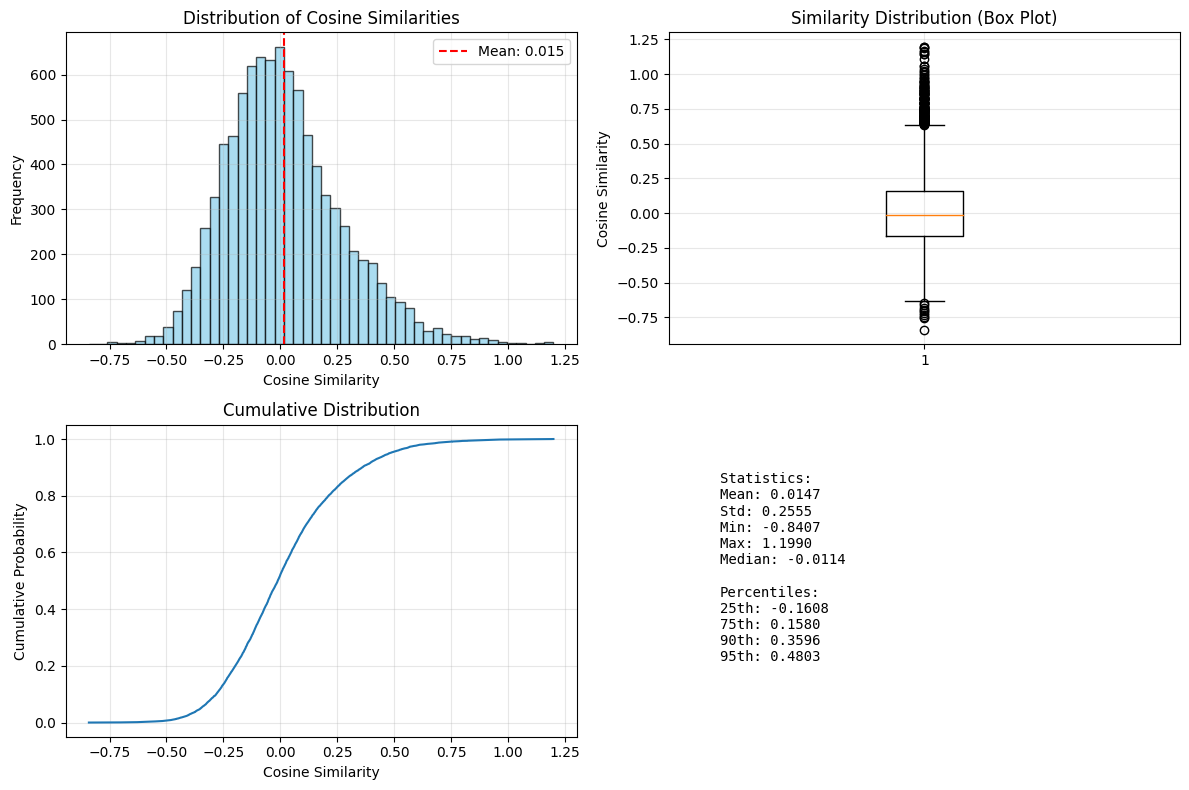

In [ ]:
# Cell 13: Visualize similarity distribution
print("Creating similarity distribution plot...")

plt.figure(figsize=(12, 8))

# Main histogram
plt.subplot(2, 2, 1)
plt.hist(cosine_similarities, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities')
plt.axvline(np.mean(cosine_similarities), color='red', linestyle='--', 
           label=f'Mean: {np.mean(cosine_similarities):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(2, 2, 2)
plt.boxplot(cosine_similarities)
plt.ylabel('Cosine Similarity')
plt.title('Similarity Distribution (Box Plot)')
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(2, 2, 3)
sorted_similarities = np.sort(cosine_similarities)
y_vals = np.arange(1, len(sorted_similarities) + 1) / len(sorted_similarities)
plt.plot(sorted_similarities, y_vals)
plt.xlabel('Cosine Similarity')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.grid(True, alpha=0.3)

# Statistics text
plt.subplot(2, 2, 4)
plt.axis('off')
stats_text = f"""
Statistics:
Mean: {np.mean(cosine_similarities):.4f}
Std: {np.std(cosine_similarities):.4f}
Min: {np.min(cosine_similarities):.4f}
Max: {np.max(cosine_similarities):.4f}
Median: {np.median(cosine_similarities):.4f}

Percentiles:
25th: {np.percentile(cosine_similarities, 25):.4f}
75th: {np.percentile(cosine_similarities, 75):.4f}
90th: {np.percentile(cosine_similarities, 90):.4f}
95th: {np.percentile(cosine_similarities, 95):.4f}
"""
plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'similarity_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

Analyzing feature distributions...


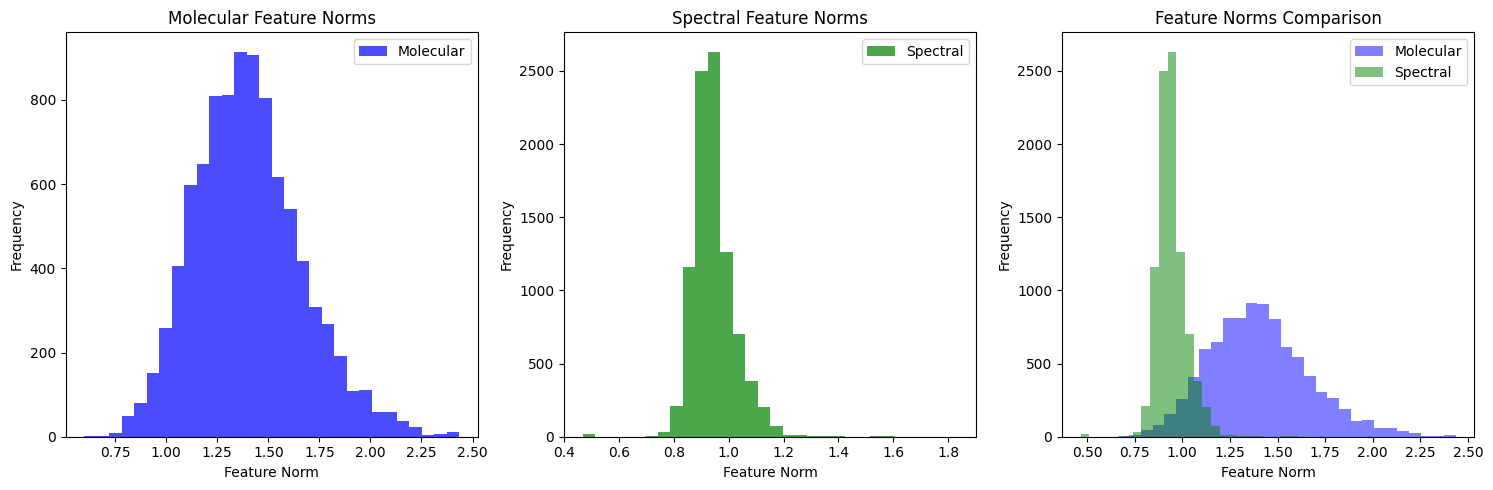

Molecular features - Mean norm: 1.4032, Std: 0.2633
Spectral features - Mean norm: 0.9438, Std: 0.0781


In [ ]:
# Cell 14: Analyze feature distributions
print("Analyzing feature distributions...")

# Plot feature magnitude distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
mol_norms = np.linalg.norm(all_molecular_features, axis=1)
plt.hist(mol_norms, bins=30, alpha=0.7, label='Molecular', color='blue')
plt.xlabel('Feature Norm')
plt.ylabel('Frequency')
plt.title('Molecular Feature Norms')
plt.legend()

plt.subplot(1, 3, 2)
spec_norms = np.linalg.norm(all_spectral_features, axis=1)
plt.hist(spec_norms, bins=30, alpha=0.7, label='Spectral', color='green')
plt.xlabel('Feature Norm')
plt.ylabel('Frequency')
plt.title('Spectral Feature Norms')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(mol_norms, bins=30, alpha=0.5, label='Molecular', color='blue')
plt.hist(spec_norms, bins=30, alpha=0.5, label='Spectral', color='green')
plt.xlabel('Feature Norm')
plt.ylabel('Frequency')
plt.title('Feature Norms Comparison')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_norms.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Molecular features - Mean norm: {np.mean(mol_norms):.4f}, Std: {np.std(mol_norms):.4f}")
print(f"Spectral features - Mean norm: {np.mean(spec_norms):.4f}, Std: {np.std(spec_norms):.4f}")